In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import requests
# from bs4 import BeautifulSoup
# import json
import time
import random
from fake_useragent import UserAgent

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# from sklearn.metrics import silhouette_score
# from scipy.cluster.hierarchy import dendrogram, linkage
# from scipy.spatial.distance import cdist

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Crawl Data 

In [99]:
def crawl_tiki_products(category_id=1789, num_pages=10):
    print(f"Data crawling from Tiki.vn (Category ID: {category_id})...")
    
    ua = UserAgent()
    products = []
    for page in range(1, num_pages + 1):
        try:
            # Tiki API endpoint
            url = f"https://tiki.vn/api/personalish/v1/blocks/listings?limit=40&category={category_id}&page={page}"
            headers = {
                'User-Agent': ua.random,
                'Accept': 'application/json, text/plain, */*',
                'Accept-Language': 'vi-VN,vi;q=0.9,en-US;q=0.8,en;q=0.7',
                'Referer': 'https://tiki.vn/',
                'x-guest-token': 'token'
            }
            response = requests.get(url, headers=headers, timeout=10)
            if response.status_code == 200:
                data = response.json()
                if 'data' in data:
                    for item in data['data']:
                        try:
                            product = {
                                'product_id': item.get('id', np.nan),
                                'name': item.get('name', 'Unknown'),
                                'price': item.get('price', 0),
                                'original_price': item.get('original_price', 0),
                                'discount': item.get('discount_rate', 0),
                                'rating': item.get('rating_average', 0),
                                'review_count': item.get('review_count', 0),
                                'sold_count': item.get('quantity_sold', {}).get('value', 0),
                                'brand': item.get('brand_name', 'Unknown'),
                                'category': category_id
                            }
                            products.append(product)
                        except Exception as e:
                            continue
                print(f"Finished crawling page {page}/{num_pages} - Total: {len(products)} products")
                time.sleep(random.uniform(1, 3))  # Tránh block
            else:
                print(f"Error page {page}: Status code {response.status_code}")
        except Exception as e:
            print(f"Error page {page}: {str(e)}")
            continue
    
    return pd.DataFrame(products)

Generate transactions data from products data

In [100]:
def generate_customer_transactions(df_products, n_customers=500, n_transactions=5000):
    # Từ tiki products, tạo dữ liệu giao dịch giả lập
    print("\nCreating customer transaction data")
    np.random.seed(42)
    transactions = []
    # Các nhóm khách hàng
    customer_segments = {
        'VIP': 
            {'n': int(n_customers * 0.1), 
             'freq_range': (10, 30), 
             'amount_multiplier': 2.5},
        'Regular': 
            {'n': int(n_customers * 0.3), 
             'freq_range': (5, 15), 
             'amount_multiplier': 1.5},
        'Occasional': 
            {'n': int(n_customers * 0.4), 
             'freq_range': (2, 8), 
             'amount_multiplier': 1.0},
        'One-time': 
            {'n': int(n_customers * 0.2), 
             'freq_range': (1, 3), 
             'amount_multiplier': 0.8}
    }
    customer_id = 10000
    transaction_id = 1
    
    for segment, config in customer_segments.items():
        for _ in range(config['n']):
            # Số lần mua
            n_purchases = np.random.randint(config['freq_range'][0], config['freq_range'][1])
            # Tạo giao dịch
            for purchase in range(n_purchases):
                # Chọn ngẫu nhiên 1-5 sản phẩm trong 1 lần mua
                n_items = np.random.randint(1, 6)
                selected_products = df_products.sample(n=min(n_items, len(df_products)))
                # Tạo thời gian giao dịch trong 12 tháng trước đó
                days_ago = np.random.randint(0, 365)
                transaction_date = datetime.now() - timedelta(days=days_ago)
                for _, product in selected_products.iterrows():
                    quantity = np.random.choice([1, 2, 3, 4], p=[0.6, 0.25, 0.1, 0.05])
                    # Giá thực tế (có thể có discount)
                    actual_price = product['price'] if product['price'] > 0 else product['original_price']
                    transaction = {
                        'transaction_id': f'TXN{transaction_id:06d}',
                        'customer_id': customer_id,
                        'product_id': product['product_id'],
                        'product_name': product['name'],
                        'quantity': quantity,
                        'unit_price': actual_price * config['amount_multiplier'],
                        'total_amount': actual_price * quantity * config['amount_multiplier'],
                        'transaction_date': transaction_date,
                        'brand': product['brand'],
                        'rating': product['rating'],
                        'customer_segment': segment
                    }
                    transactions.append(transaction)
                    transaction_id += 1
            customer_id += 1
    df_transactions = pd.DataFrame(transactions)
    # Giới hạn số giao dịch
    if len(df_transactions) > n_transactions:
        df_transactions = df_transactions.sample(n=n_transactions, random_state=42)
    print(f"Created {len(df_transactions):,} transactions from {df_transactions['customer_id'].nunique()} customers")
    return df_transactions

Crawling

In [101]:
print("DATA CRAWLING FROM TIKI.VN")
# categories ID
categories = {
    1789: "Điện thoại - Máy tính bảng",
    1846: "Laptop - Máy vi tính",
    8322: "Đồng hồ"
}

all_products = []
for cat_id, cat_name in categories.items():
    print(f"\nCrawling category: {cat_name}")
    df_cat = crawl_tiki_products(category_id=cat_id, num_pages=5)
    all_products.append(df_cat)
    print(f"Crawled {len(df_cat)} product from {cat_name}")

# Gộp tất cả sản phẩm
df_products = pd.concat(all_products, ignore_index=True)
print(f"\nTotal product crawled: {len(df_products):,}")
# Lưu sản phẩm đã crawl
df_products.to_csv('tiki_products.csv', index=False, encoding='utf-8-sig')
print("Saved product list to 'tiki_products.csv'")
# Tạo dữ liệu giao dịch từ sản phẩm thật
df_raw = generate_customer_transactions(df_products, n_customers=500, n_transactions=5000)
# Lưu dữ liệu thô
df_raw.to_csv('raw_transactions.csv', index=False, encoding='utf-8-sig')
print("Save transactions data to 'raw_transactions.csv'")

DATA CRAWLING FROM TIKI.VN

Crawling category: Điện thoại - Máy tính bảng
Data crawling from Tiki.vn (Category ID: 1789)...
Finished crawling page 1/5 - Total: 40 products
Finished crawling page 1/5 - Total: 40 products
Finished crawling page 2/5 - Total: 71 products
Finished crawling page 2/5 - Total: 71 products
Finished crawling page 3/5 - Total: 90 products
Finished crawling page 3/5 - Total: 90 products
Finished crawling page 4/5 - Total: 124 products
Finished crawling page 4/5 - Total: 124 products
Finished crawling page 5/5 - Total: 143 products
Finished crawling page 5/5 - Total: 143 products
Crawled 143 product from Điện thoại - Máy tính bảng

Crawling category: Laptop - Máy vi tính
Data crawling from Tiki.vn (Category ID: 1846)...
Crawled 143 product from Điện thoại - Máy tính bảng

Crawling category: Laptop - Máy vi tính
Data crawling from Tiki.vn (Category ID: 1846)...
Finished crawling page 1/5 - Total: 39 products
Finished crawling page 1/5 - Total: 39 products
Finished c

In [102]:
# Load dữ liệu từ file đã lưu để đảm bảo consistency
print("\nLOADING SAVED DATA FOR CONSISTENCY:")
df_raw = pd.read_csv('raw_transactions.csv')
df_products = pd.read_csv('tiki_products.csv')
print("Loaded data from saved files.")


LOADING SAVED DATA FOR CONSISTENCY:
Loaded data from saved files.
Loaded data from saved files.


In [103]:
print("PRODUCTS DETAIL")
print(f"Number of products: {len(df_products):,}")
print(f"Number of brands: {df_products['brand'].nunique()}")
print(f"\nAverage price: {df_products['price'].mean():,.0f} VNĐ")
print(f"Average rating: {df_products['rating'].mean():.2f}/5")
print(f"Total reviews: {df_products['review_count'].sum():,}")

print("\nProducts data:")
display(df_products.head(10))
print("\nProduct statistics:")
print(df_products.describe())

PRODUCTS DETAIL
Number of products: 541
Number of brands: 102

Average price: 1,399,131 VNĐ
Average rating: 4.11/5
Total reviews: 129,391

Products data:


,product_id,name,price,original_price,discount,rating,review_count,sold_count,brand,category
0,277930407,Điện thoại Tecno Spark GO 1 (3GB/64GB) - Hàng Chính Hãng,2190000,2190000,0,4.7,3,72,Tecno,1789
1,277812880,Máy Tính Bảng Galaxy Tab S10 FE Wifi (8GB/128GB) - Hàng Chính Hãng,8990000,11990000,25,5.0,1,8,Samsung,1789
2,277811118,Điện Thoại Xiaomi Redmi Note 14 5G 8GB/256GB - Hàng Chính Hãng,6029000,7290000,17,0.0,0,1,Xiaomi,1789
3,277777809,"Điện thoại Samsung Galaxy A26 5G (8/128GB), Mặt lưng kính, AI-Circle to Search, Camera HDR chụp đêm sáng rõ - Hàng chính hãng",5050000,6990000,28,5.0,18,2747,Samsung,1789
4,277737595,Điện Thoại Samsung Galaxy A06 5G 4GB/128GB - Hàng Chính Hãng,2639000,4490000,41,4.8,6,17,Samsung,1789
5,277619147,Máy tính bảng iPad Gen 11 (A16) WiFi,8490000,9990000,15,5.0,48,306,Apple,1789
6,277614251,Apple iPad Air M3 11-Inch Wi-Fi,13990000,16990000,18,5.0,5,30,Apple,1789
7,277512620,Điện Thoại Samsung Galaxy A36 5G 8GB/128GB - Hàng Chính Hãng,6679000,8290000,19,5.0,3,8,Samsung,1789
8,277512611,Điện Thoại Samsung Galaxy A56 5G 8GB/128GB - Hàng Chính Hãng,8029000,9990000,20,5.0,1,2,Samsung,1789
9,277466537,Điện Thoại Samsung Galaxy A36 5G - Hàng Chính Hãng,5990000,8140000,26,5.0,11,1227,Samsung,1789



Product statistics:
         product_id         price  original_price    discount      rating  \
count  5.410000e+02  5.410000e+02    5.410000e+02  541.000000  541.000000   
mean   1.991664e+08  1.399131e+06    1.664958e+06   14.665434    4.107763   
std    1.019498e+08  3.339809e+06    3.821809e+06   12.912558    1.723179   
min    4.169110e+05  7.000000e+03    7.000000e+03    0.000000    0.000000   
25%    1.346415e+08  1.200000e+05    1.450000e+05    1.000000    4.500000   
50%    2.713809e+08  1.950000e+05    2.400000e+05   17.000000    4.800000   
75%    2.766596e+08  1.460000e+06    1.550000e+06   24.000000    5.000000   
max    2.786426e+08  3.749000e+07    3.799000e+07   66.000000    5.000000   

       review_count    sold_count     category  
count    541.000000    541.000000   541.000000  
mean     239.170055   2183.256932  4225.018484  
std      910.564803   7212.047919  3140.614013  
min        0.000000      1.000000  1789.000000  
25%        2.000000     14.000000  1789.

In [104]:
print("TRANSACTIONS DETAIL")
print(f"Number of transactions: {len(df_raw):,}")
print(f"Number of customer: {df_raw['customer_id'].nunique():,}")
print(f"Number of products purchased: {df_raw['product_id'].nunique():,}")
print(f"Time range: {df_raw['transaction_date'].min()} đến {df_raw['transaction_date'].max()}")
print(f"Total revenue: {df_raw['total_amount'].sum():,.0f} VNĐ")

print("\nCustomer segmentation:")
print(df_raw.groupby('customer_segment')['customer_id'].nunique())
print("\nFirst 5 transactions:")
display(df_raw.head())
print("\nColumns information:")
df_raw.info()

TRANSACTIONS DETAIL
Number of transactions: 5,000
Number of customer: 476
Number of products purchased: 541
Time range: 2024-11-05 16:13:27.438273 đến 2025-11-04 16:13:30.875271
Total revenue: 16,478,216,398 VNĐ

Customer segmentation:
customer_segment
Occasional    197
One-time       79
Regular       150
VIP            50
Name: customer_id, dtype: int64

First 5 transactions:


,transaction_id,customer_id,product_id,product_name,quantity,unit_price,total_amount,transaction_date,brand,rating,customer_segment
0,TXN010100,10455,419320,Máy In Laser Đơn Năng Canon LBP 6030 - Hàng chính hãng,1,2208000.0,2208000.0,2025-07-14 16:13:31.181271,Canon,4.6,One-time
1,TXN003001,10056,742901,Phần Mềm Diệt Virus Trend Micro Internet Security 11 - 2017 - Dùng cho 3 PC Win/Mac,2,523500.0,1047000.0,2025-07-12 16:13:28.334292,Trend Micro,4.8,Regular
2,TXN006886,10191,275246760,"Hộp mực TN B022 Prospect dùng cho máy in Brother HL-B2000D, HL-B2080DW, DCP-B7535DW, MFC-B7715DW - Hàng chính hãng",1,202950.0,202950.0,2025-10-21 16:13:29.972278,Prospect,4.5,Regular
3,TXN010006,10430,164318521,Điện thoại bàn Panasonic KX-TGF320 hàng chính hãng,2,2000000.0,4000000.0,2025-06-02 16:13:31.142274,Panasonic,5.0,One-time
4,TXN003300,10068,275859546,Pin dành cho laptop HP Pavilion 14-ce 14 ce series 14-ce1014TU (HT03XL) hàng nhập khẩu,1,862560.0,862560.0,2025-06-26 16:13:28.454280,MINHHA,0.0,Regular



Columns information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    5000 non-null   object 
 1   customer_id       5000 non-null   int64  
 2   product_id        5000 non-null   int64  
 3   product_name      5000 non-null   object 
 4   quantity          5000 non-null   int64  
 5   unit_price        5000 non-null   float64
 6   total_amount      5000 non-null   float64
 7   transaction_date  5000 non-null   object 
 8   brand             3165 non-null   object 
 9   rating            5000 non-null   float64
 10  customer_segment  5000 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 429.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  ---

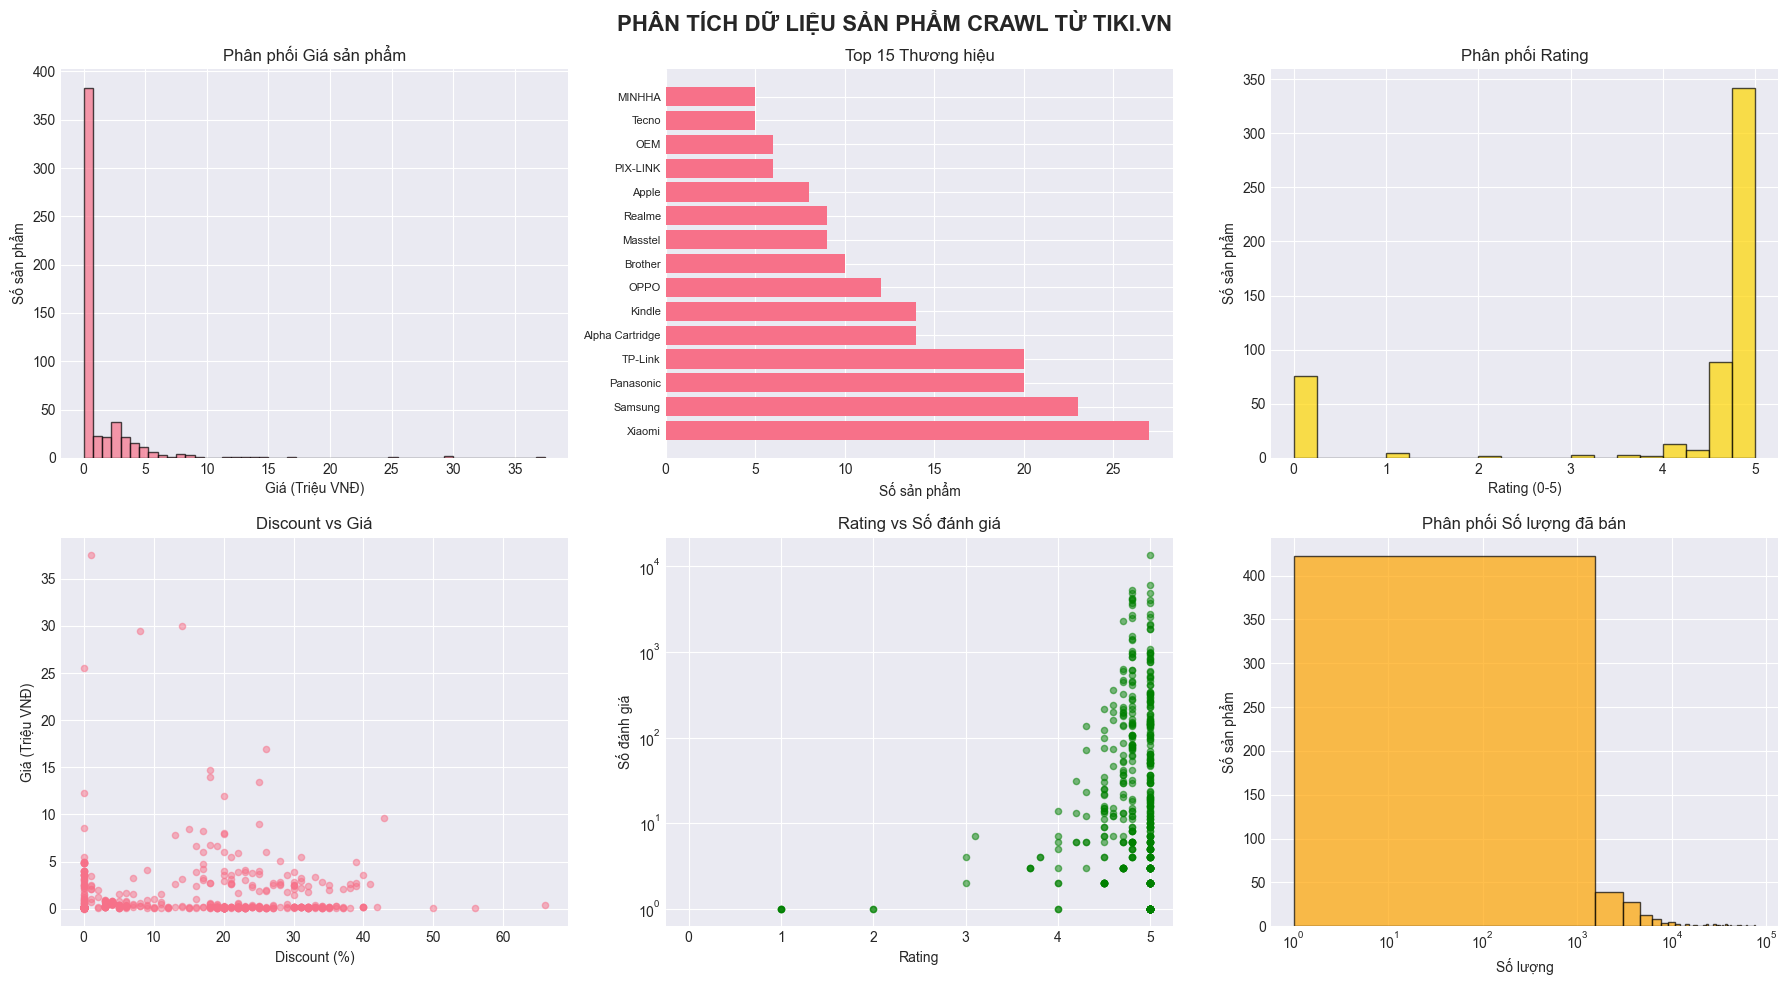

Saved chart: '01_tiki_products_analysis.png'


In [105]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('PHÂN TÍCH DỮ LIỆU SẢN PHẨM CRAWL TỪ TIKI.VN', fontsize=16, fontweight='bold')

# 1. Phân phối giá sản phẩm
axes[0, 0].hist(df_products['price'][df_products['price'] > 0]/1000000, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Phân phối Giá sản phẩm')
axes[0, 0].set_xlabel('Giá (Triệu VNĐ)')
axes[0, 0].set_ylabel('Số sản phẩm')

# 2. Top 15 thương hiệu
top_brands = df_products['brand'].value_counts().head(15)
axes[0, 1].barh(range(len(top_brands)), top_brands.values)
axes[0, 1].set_yticks(range(len(top_brands)))
axes[0, 1].set_yticklabels(top_brands.index, fontsize=8)
axes[0, 1].set_title('Top 15 Thương hiệu')
axes[0, 1].set_xlabel('Số sản phẩm')

# 3. Phân phối Rating
axes[0, 2].hist(df_products['rating'], bins=20, edgecolor='black', alpha=0.7, color='gold')
axes[0, 2].set_title('Phân phối Rating')
axes[0, 2].set_xlabel('Rating (0-5)')
axes[0, 2].set_ylabel('Số sản phẩm')

# 4. Discount vs Price
axes[1, 0].scatter(df_products['discount'], df_products['price']/1000000, alpha=0.5, s=20)
axes[1, 0].set_title('Discount vs Giá')
axes[1, 0].set_xlabel('Discount (%)')
axes[1, 0].set_ylabel('Giá (Triệu VNĐ)')

# 5. Rating vs Review Count
axes[1, 1].scatter(df_products['rating'], df_products['review_count'], alpha=0.5, s=20, color='green')
axes[1, 1].set_title('Rating vs Số đánh giá')
axes[1, 1].set_xlabel('Rating')
axes[1, 1].set_ylabel('Số đánh giá')
axes[1, 1].set_yscale('log')

# 6. Sold Count Distribution
axes[1, 2].hist(df_products['sold_count'][df_products['sold_count'] > 0], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 2].set_title('Phân phối Số lượng đã bán')
axes[1, 2].set_xlabel('Số lượng')
axes[1, 2].set_ylabel('Số sản phẩm')
axes[1, 2].set_xscale('log')

plt.tight_layout()
plt.savefig('01_tiki_products_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved chart: '01_tiki_products_analysis.png'")

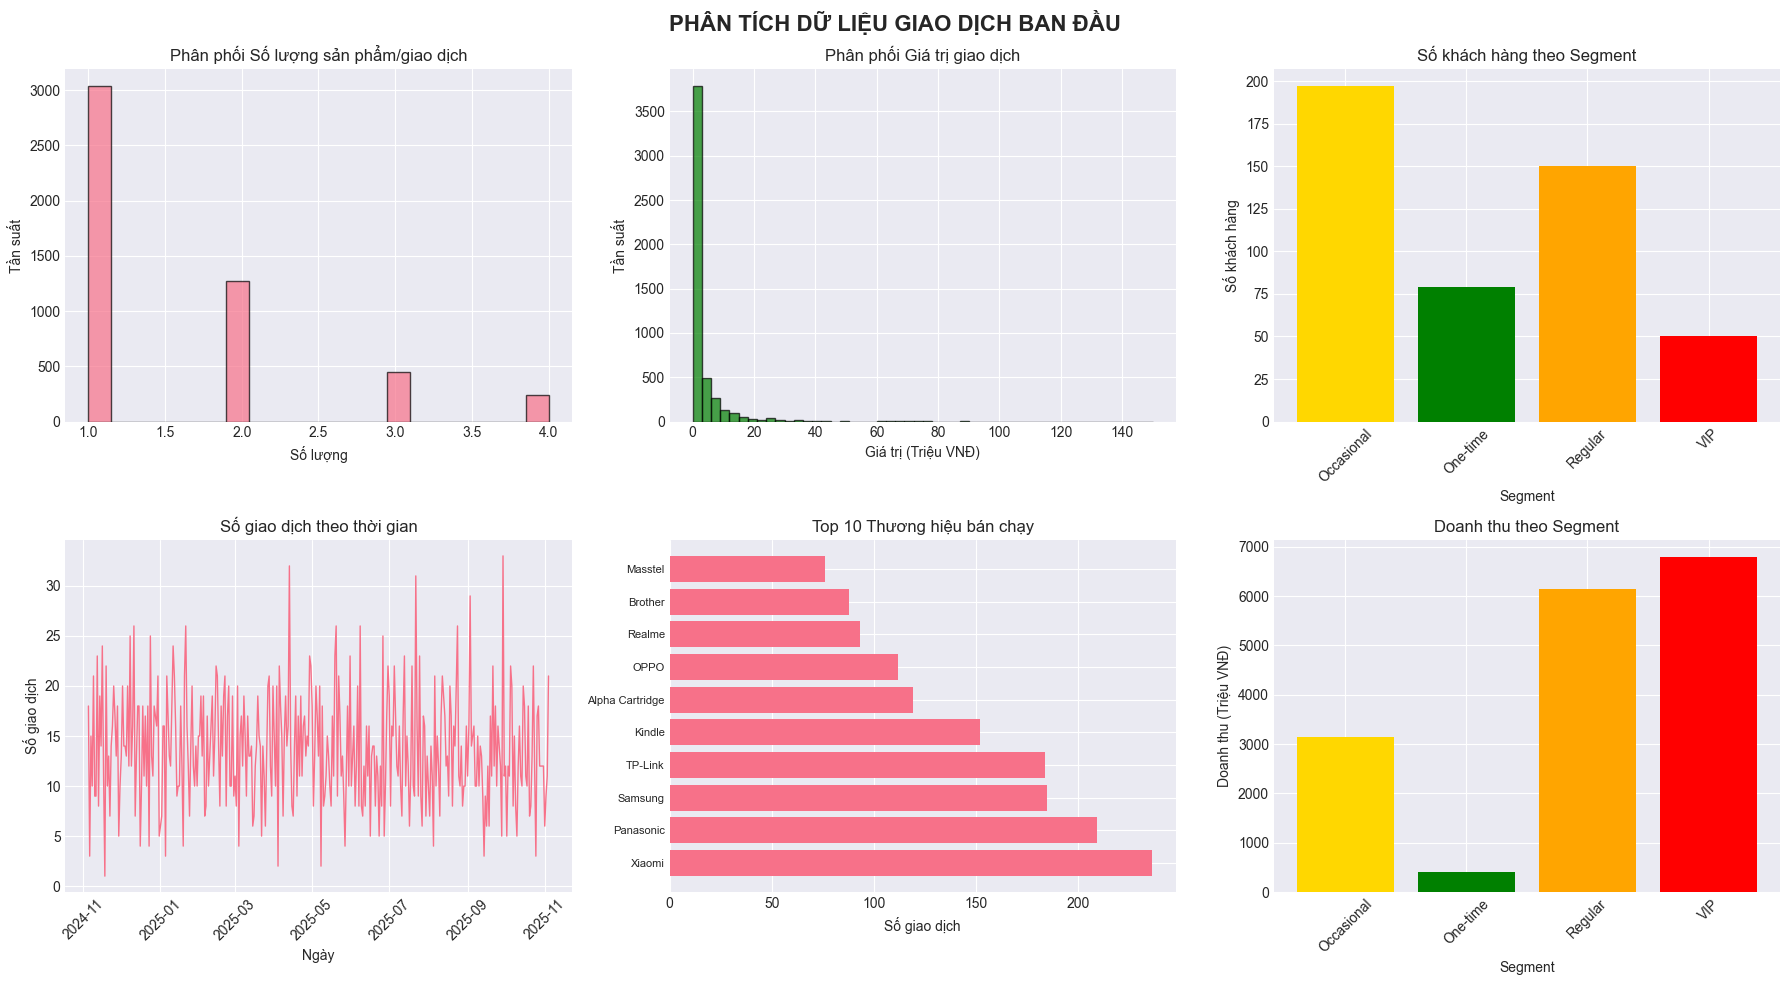

Saved chart: '02_raw_transactions_visualization.png'


In [106]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('PHÂN TÍCH DỮ LIỆU GIAO DỊCH BAN ĐẦU', fontsize=16, fontweight='bold')

# 1. Phân phối số lượng mua
axes[0, 0].hist(df_raw['quantity'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Phân phối Số lượng sản phẩm/giao dịch')
axes[0, 0].set_xlabel('Số lượng')
axes[0, 0].set_ylabel('Tần suất')

# 2. Phân phối giá trị giao dịch
axes[0, 1].hist(df_raw['total_amount']/1000000, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Phân phối Giá trị giao dịch')
axes[0, 1].set_xlabel('Giá trị (Triệu VNĐ)')
axes[0, 1].set_ylabel('Tần suất')

# 3. Phân bố theo Customer Segment
segment_counts = df_raw.groupby('customer_segment')['customer_id'].nunique()
axes[0, 2].bar(segment_counts.index, segment_counts.values, color=['gold', 'green', 'orange', 'red'])
axes[0, 2].set_title('Số khách hàng theo Segment')
axes[0, 2].set_xlabel('Segment')
axes[0, 2].set_ylabel('Số khách hàng')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Giao dịch theo thời gian
df_raw['transaction_date'] = pd.to_datetime(df_raw['transaction_date'])
transactions_by_date = df_raw.groupby(df_raw['transaction_date'].dt.date).size()
axes[1, 0].plot(transactions_by_date.index, transactions_by_date.values, linewidth=1)
axes[1, 0].set_title('Số giao dịch theo thời gian')
axes[1, 0].set_xlabel('Ngày')
axes[1, 0].set_ylabel('Số giao dịch')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Top 10 thương hiệu được mua nhiều nhất
top_brands_sold = df_raw['brand'].value_counts().head(10)
axes[1, 1].barh(range(len(top_brands_sold)), top_brands_sold.values)
axes[1, 1].set_yticks(range(len(top_brands_sold)))
axes[1, 1].set_yticklabels(top_brands_sold.index, fontsize=8)
axes[1, 1].set_title('Top 10 Thương hiệu bán chạy')
axes[1, 1].set_xlabel('Số giao dịch')

# 6. Doanh thu theo segment
revenue_by_segment = df_raw.groupby('customer_segment')['total_amount'].sum()/1000000
axes[1, 2].bar(revenue_by_segment.index, revenue_by_segment.values, color=['gold', 'green', 'orange', 'red'])
axes[1, 2].set_title('Doanh thu theo Segment')
axes[1, 2].set_xlabel('Segment')
axes[1, 2].set_ylabel('Doanh thu (Triệu VNĐ)')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('02_raw_transactions_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved chart: '02_raw_transactions_visualization.png'")

In [107]:
print("\nOverview:")
print(f"Number of transactions: {len(df_raw):,}")
print(f"Number of columns: {len(df_raw.columns)}")

print("\nMISSING VALUES:")
missing_stats = pd.DataFrame({
    'Missing_Count': df_raw.isnull().sum(),
    'Missing_Percentage (%)': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
})
missing_stats = missing_stats[missing_stats['Missing_Count'] > 0]  
display(missing_stats)

# tổng quan về missing values
total_missing = df_raw.isnull().sum().sum()
print(f"Total missing values across all columns: {total_missing:,}")
if total_missing > 0:
    print("Columns with missing values:")
    for col in df_raw.columns:
        missing_count = df_raw[col].isnull().sum()
        if missing_count > 0:
            print(f"   {col}: {missing_count:,} ({missing_count/len(df_raw)*100:.2f}%)")

print("\nDUPLICATE VALUES:")
n_duplicates = df_raw.duplicated().sum()
print(f"Duplicate transaction number: {n_duplicates:,} ({n_duplicates/len(df_raw)*100:.2f}%)")

print("\nOUTLIERS:")
# Quantity
q_negative = (df_raw['quantity'] < 0).sum()
q_zero = (df_raw['quantity'] == 0).sum()
print(f"Negative quantity: {q_negative:,}")
print(f"Quantity = 0: {q_zero:,}")

# Price
p_negative = (df_raw['unit_price'] < 0).sum()
p_zero = (df_raw['unit_price'] == 0).sum()
print(f"Negative unit price: {p_negative:,}")
print(f"Unit Price = 0: {p_zero:,}")

# dùng IQR
Q1_qty = df_raw['quantity'].quantile(0.25)
Q3_qty = df_raw['quantity'].quantile(0.75)
IQR_qty = Q3_qty - Q1_qty
outliers_qty = ((df_raw['quantity'] < (Q1_qty - 1.5 * IQR_qty)) | 
                (df_raw['quantity'] > (Q3_qty + 1.5 * IQR_qty))).sum()
print(f"Outliers in Quantity (IQR): {outliers_qty:,} ({outliers_qty/len(df_raw)*100:.2f}%)")

Q1_price = df_raw['total_amount'].quantile(0.25)
Q3_price = df_raw['total_amount'].quantile(0.75)
IQR_price = Q3_price - Q1_price
outliers_price = ((df_raw['total_amount'] < (Q1_price - 1.5 * IQR_price)) | 
                  (df_raw['total_amount'] > (Q3_price + 1.5 * IQR_price))).sum()
print(f"Outliers in Total Amount (IQR): {outliers_price:,} ({outliers_price/len(df_raw)*100:.2f}%)")


Overview:
Number of transactions: 5,000
Number of columns: 11

MISSING VALUES:


,Missing_Count,Missing_Percentage (%)
brand,1835,36.7


Total missing values across all columns: 1,835
Columns with missing values:
   brand: 1,835 (36.70%)

DUPLICATE VALUES:
Duplicate transaction number: 0 (0.00%)

OUTLIERS:
Negative quantity: 0
Quantity = 0: 0
Negative unit price: 0
Unit Price = 0: 0
Outliers in Quantity (IQR): 245 (4.90%)
Outliers in Total Amount (IQR): 659 (13.18%)


In [108]:
print("\nSTATISTICAL SUMMARY:")
statist = df_raw[['quantity', 'unit_price', 'total_amount', 'rating']].describe()
display(statist)

print("\nBUSINESS INSIGHTS:")
print(f"Average transaction/customer: {len(df_raw)/df_raw['customer_id'].nunique():.2f}")
print(f"Average value/transaction: {df_raw['total_amount'].mean():,.0f} VNĐ")
print(f"Total revenue: {df_raw['total_amount'].sum():,.0f} VNĐ")


STATISTICAL SUMMARY:


,quantity,unit_price,total_amount,rating
count,5000.00000,5.000000e+03,5.000000e+03,5000.000000
mean,1.58020,2.092496e+06,3.295643e+06,4.118780
std,0.84647,4.943168e+06,8.340360e+06,1.714289
min,1.00000,8.000000e+03,8.000000e+03,0.000000
25%,1.00000,1.747500e+05,2.175000e+05,4.500000
50%,1.00000,3.275000e+05,5.000000e+05,4.800000
75%,2.00000,2.022500e+06,2.790000e+06,5.000000
max,4.00000,7.497500e+07,1.499600e+08,5.000000



BUSINESS INSIGHTS:
Average transaction/customer: 10.50
Average value/transaction: 3,295,643 VNĐ
Total revenue: 16,478,216,398 VNĐ


Processing

In [109]:
df_clean = df_raw.copy()
initial_rows = len(df_clean)
print(f"Starting with {initial_rows:,} transactions")
print(f"Columns: {len(df_clean.columns)}")
df_original = df_clean.copy()  # Dữ liệu gốc

Starting with 5,000 transactions
Columns: 11

Columns: 11


Missing values

In [110]:
print("Missing values before processing:")
for col in df_clean.columns:
    missing_count = df_clean[col].isnull().sum()
    if missing_count > 0:
        print(f"{col}: {missing_count:,} ({missing_count/len(df_clean)*100:.2f}%)")

before_missing = df_clean.isnull().sum().sum()
print(f"Total: {before_missing:,}")

# fill theo category phổ biến của mỗi brand
if 'brand' in df_clean.columns and df_clean['brand'].isnull().sum() > 0:
    df_products_ref = pd.read_csv('tiki_products.csv')
    # mapping từ product_id sang category
    product_category_map = df_products_ref.set_index('product_id')['category'].to_dict()
    # Thêm category vào transactions dựa trên product_id
    df_clean['category'] = df_clean['product_id'].map(product_category_map)
    # Tìm brand phổ biến nhất cho từng category
    category_top_brands = {}
    for category in df_products_ref['category'].unique():
        category_products = df_products_ref[df_products_ref['category'] == category]
        # Lấy brand phổ biến nhất trong category - Nan
        valid_brands = category_products['brand'].dropna()
        if len(valid_brands) > 0:
            top_brand = valid_brands.value_counts().index[0]
            category_top_brands[category] = top_brand
            print(f"Category {category}: Most popular brand = {top_brand}")
        else:
            # fill unknown nếu không có brand
            category_top_brands[category] = 'Unknown'
            print(f"Category {category}: No valid brands found, using 'Unknown'")
    # Fill missing brands theo category
    brand_missing_count = df_clean['brand'].isnull().sum()
    def fill_brand_by_category(row):
        if pd.isnull(row['brand']) and pd.notnull(row['category']):
            return category_top_brands.get(row['category'], 'Unknown')
        return row['brand']
    df_clean['brand'] = df_clean.apply(fill_brand_by_category, axis=1)
    
    filled_count = brand_missing_count - df_clean['brand'].isnull().sum()
    print(f"Done.")

    # Xóa column category tạm thời
    df_clean = df_clean.drop('category', axis=1)

# Xử lý missing values khác 
remaining_missing = df_clean.isnull().sum().sum()
if remaining_missing > 0:
    print(f"\nRemoving remaining {remaining_missing} missing values...")
    df_clean = df_clean.dropna()

after_missing = df_clean.isnull().sum().sum()
rows_after_missing = len(df_clean)

print(f"Before: {before_missing:,} missing values")
print(f"After: {after_missing:,} missing values") 
print(f"Rows: {initial_rows:,} -> {rows_after_missing:,} ({rows_after_missing/initial_rows*100:.2f}%)")

# Lưu trạng thái sau bước 1
df_after_missing = df_clean.copy()

# lưu data sau khi fill missing vào file cleaned_transactions.csv
df_clean.to_csv('cleaned_transactions.csv', index=False, encoding='utf-8-sig')
print("Saved cleaned data to 'cleaned_transactions.csv'")

Missing values before processing:
brand: 1,835 (36.70%)
Total: 1,835
Category 1789: Most popular brand = Xiaomi
Category 1846: Most popular brand = TP-Link
Category 8322: No valid brands found, using 'Unknown'

brand: 1,835 (36.70%)
Total: 1,835
Category 1789: Most popular brand = Xiaomi
Category 1846: Most popular brand = TP-Link
Category 8322: No valid brands found, using 'Unknown'
Done.
Before: 1,835 missing values
After: 0 missing values
Rows: 5,000 -> 5,000 (100.00%)
Done.
Before: 1,835 missing values
After: 0 missing values
Rows: 5,000 -> 5,000 (100.00%)
Saved cleaned data to 'cleaned_transactions.csv'
Saved cleaned data to 'cleaned_transactions.csv'


Duplicate

In [111]:
before_dup = len(df_clean)
n_duplicates = df_clean.duplicated().sum()
print(f"Found {n_duplicates:,} duplicate transactions ({n_duplicates/len(df_clean)*100:.2f}%)")

if n_duplicates > 0:
    # 1 vài sample bị duplicate
    duplicate_samples = df_clean[df_clean.duplicated()].head(3)
    for idx, row in duplicate_samples.iterrows():
        print(f"Transaction {row['transaction_id']}: {row['customer_id']} - {row['product_name'][:50]}...")

df_clean = df_clean.drop_duplicates()
after_dup = len(df_clean)
removed_dup = before_dup - after_dup
print(f"Removed: {removed_dup:,} duplicate transactions")
print(f"Rows: {before_dup:,} -> {after_dup:,} ({after_dup/initial_rows*100:.2f}%)")

df_after_duplicates = df_clean.copy()

Found 0 duplicate transactions (0.00%)
Removed: 0 duplicate transactions
Rows: 5,000 -> 5,000 (100.00%)


In [112]:
before_outliers = len(df_clean)
invalid_qty = (df_clean['quantity'] <= 0).sum()
invalid_price = (df_clean['unit_price'] <= 0).sum()
print(f"Quantity <=0: {invalid_qty:,}")
print(f"Unit price <=0: {invalid_price:,}")

df_clean = df_clean[(df_clean['quantity'] > 0) & (df_clean['unit_price'] > 0)]
after_invalid = len(df_clean)
removed_invalid = before_outliers - after_invalid
print(f"Removed: {removed_invalid:,}")

# loại bỏ dưới 1% và trên 99% outliers
qty_outliers_low = (df_clean['quantity'] < df_clean['quantity'].quantile(0.01)).sum()
qty_outliers_high = (df_clean['quantity'] > df_clean['quantity'].quantile(0.99)).sum()
amt_outliers_low = (df_clean['total_amount'] < df_clean['total_amount'].quantile(0.01)).sum()
amt_outliers_high = (df_clean['total_amount'] > df_clean['total_amount'].quantile(0.99)).sum()
print(f"Quantity outliers: {qty_outliers_low + qty_outliers_high:,} ({qty_outliers_low} low + {qty_outliers_high} high)")
print(f"Total amount outliers: {amt_outliers_low + amt_outliers_high:,} ({amt_outliers_low} low + {amt_outliers_high} high)")

# Loại bỏ outliers
df_clean = df_clean[df_clean['quantity'] <= df_clean['quantity'].quantile(0.99)]
df_clean = df_clean[df_clean['total_amount'] <= df_clean['total_amount'].quantile(0.99)]
df_clean = df_clean[df_clean['total_amount'] >= df_clean['total_amount'].quantile(0.01)]

after_outliers = len(df_clean)
removed_outliers = after_invalid - after_outliers
print(f"Removed: {removed_outliers:,}")

df_clean['transaction_date'] = pd.to_datetime(df_clean['transaction_date'])
df_clean['customer_id'] = df_clean['customer_id'].astype(int)
df_clean['product_id'] = df_clean['product_id'].astype(str)
print(f"Invalid values removed: {removed_invalid:,}")
print(f"Outliers removed: {removed_outliers:,}")
print(f"Total removed: {removed_invalid + removed_outliers:,}")
print(f"Rows: {before_outliers:,} → {after_outliers:,} ({after_outliers/initial_rows*100:.2f}%)")
df_final = df_clean.copy()

Quantity <=0: 0
Unit price <=0: 0
Removed: 0
Quantity outliers: 0 (0 low + 0 high)
Total amount outliers: 99 (49 low + 50 high)
Removed: 99
Invalid values removed: 0
Outliers removed: 99
Total removed: 99
Rows: 5,000 → 4,901 (98.02%)


In [113]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("DATA AFTER PROCESSING")
print("\nOverview:")
print(f"Number of transactions: {len(df_clean):,}")
print(f"Number of columns: {len(df_clean.columns)}")

print("\nMISSING VALUES:")
missing_after = df_clean.isnull().sum().sum()
print(f"Total missing values: {missing_after}")

print("\nDUPLICATE VALUES:")
dup_after = df_clean.duplicated().sum()
print(f"Number of duplicate transactions: {dup_after}")

print("\nOUTLIERS:")
print(f"Negative quantity: {(df_clean['quantity'] < 0).sum()}")
print(f"Quantity = 0: {(df_clean['quantity'] == 0).sum()}")
print(f"Negative Unit Price: {(df_clean['unit_price'] < 0).sum()}")
print(f"Unit Price = 0: {(df_clean['unit_price'] == 0).sum()}")

print("\nSTATISTICAL SUMMARY:")
# print(df_clean[['quantity', 'unit_price', 'total_amount', 'rating']].describe())
statist = df_clean[['quantity', 'unit_price', 'total_amount', 'rating']].describe()
display(statist)

DATA AFTER PROCESSING

Overview:
Number of transactions: 4,901
Number of columns: 11

MISSING VALUES:
Total missing values: 0

DUPLICATE VALUES:
Number of duplicate transactions: 0

OUTLIERS:
Negative quantity: 0
Quantity = 0: 0
Negative Unit Price: 0
Unit Price = 0: 0

STATISTICAL SUMMARY:


,quantity,unit_price,total_amount,rating
count,4901.000000,4.901000e+03,4.901000e+03,4901.000000
mean,1.578045,1.779637e+06,2.698806e+06,4.129463
std,0.842905,3.287769e+06,5.174402e+06,1.702336
min,1.000000,1.200000e+04,4.640000e+04,0.000000
25%,1.000000,1.748000e+05,2.220000e+05,4.500000
50%,1.000000,3.275000e+05,5.000000e+05,4.800000
75%,2.000000,1.960000e+06,2.640000e+06,5.000000
max,4.000000,3.684750e+07,4.047000e+07,5.000000


Data comparison

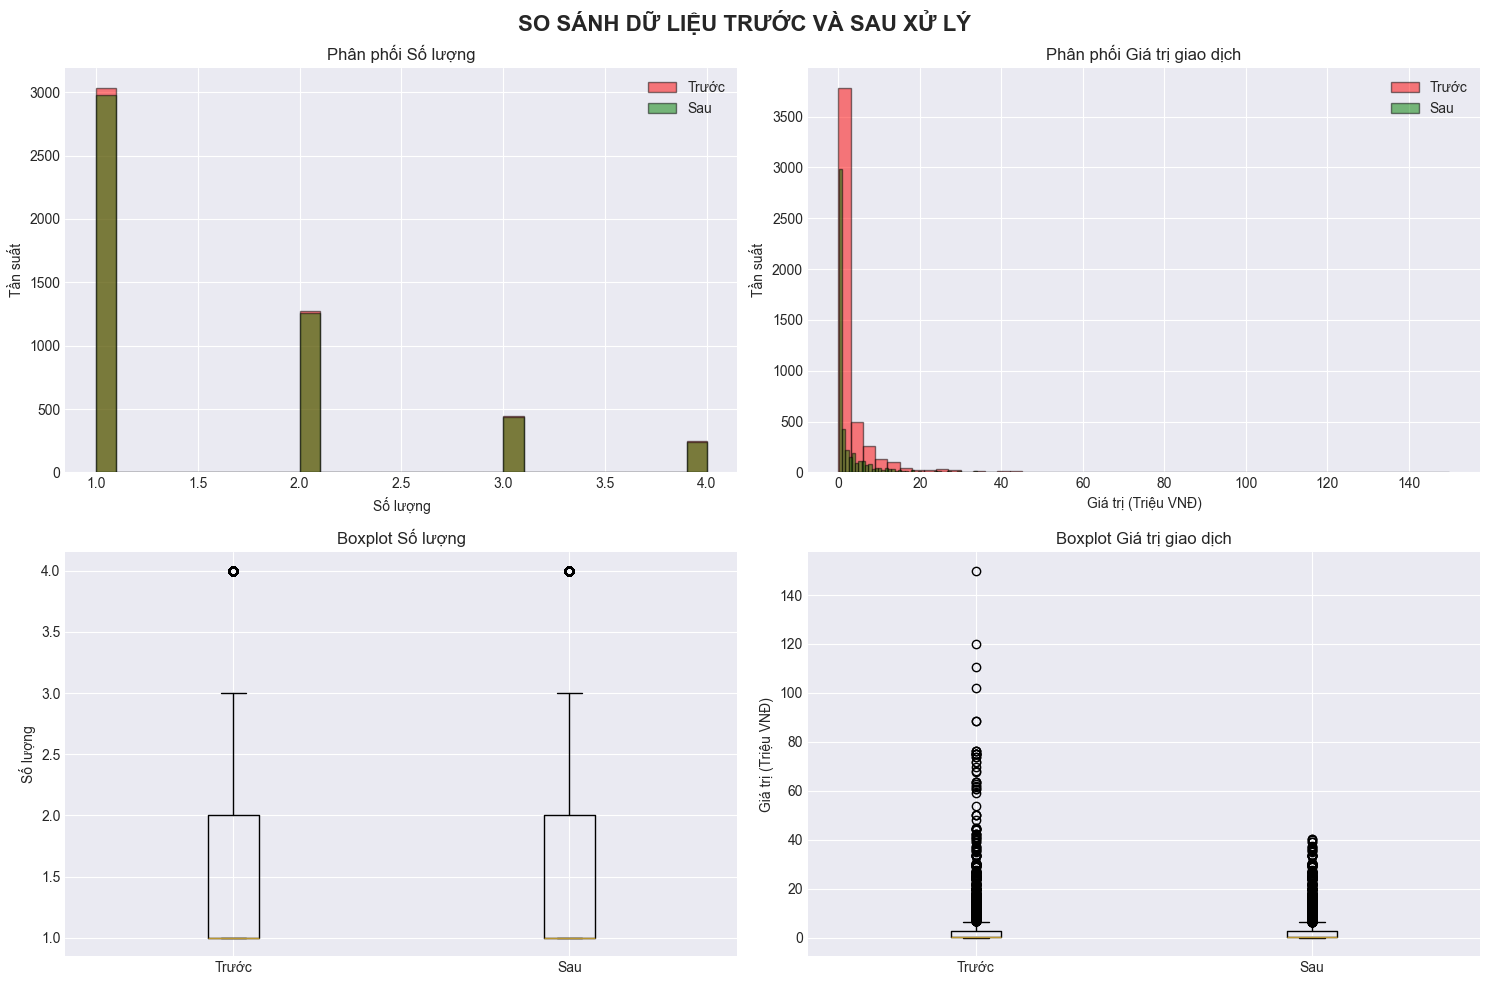

Saved chart: '03_before_after_comparison.png'


In [114]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SO SÁNH DỮ LIỆU TRƯỚC VÀ SAU XỬ LÝ', fontsize=16, fontweight='bold')

# 1. Phân phối Quantity
axes[0, 0].hist(df_raw['quantity'], bins=30, alpha=0.5, label='Trước', color='red', edgecolor='black')
axes[0, 0].hist(df_clean['quantity'], bins=30, alpha=0.5, label='Sau', color='green', edgecolor='black')
axes[0, 0].set_title('Phân phối Số lượng')
axes[0, 0].set_xlabel('Số lượng')
axes[0, 0].set_ylabel('Tần suất')
axes[0, 0].legend()

# 2. Phân phối Total Amount
axes[0, 1].hist(df_raw['total_amount']/1000000, bins=50, alpha=0.5, label='Trước', color='red', edgecolor='black')
axes[0, 1].hist(df_clean['total_amount']/1000000, bins=50, alpha=0.5, label='Sau', color='green', edgecolor='black')
axes[0, 1].set_title('Phân phối Giá trị giao dịch')
axes[0, 1].set_xlabel('Giá trị (Triệu VNĐ)')
axes[0, 1].set_ylabel('Tần suất')
axes[0, 1].legend()

# 3. Boxplot Quantity
axes[1, 0].boxplot([df_raw['quantity'], df_clean['quantity']], 
                    labels=['Trước', 'Sau'])
axes[1, 0].set_title('Boxplot Số lượng')
axes[1, 0].set_ylabel('Số lượng')

# 4. Boxplot Total Amount
axes[1, 1].boxplot([df_raw['total_amount']/1000000, df_clean['total_amount']/1000000], 
                    labels=['Trước', 'Sau'])
axes[1, 1].set_title('Boxplot Giá trị giao dịch')
axes[1, 1].set_ylabel('Giá trị (Triệu VNĐ)')

plt.tight_layout()
plt.savefig('03_before_after_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved chart: '03_before_after_comparison.png'")

Create RFM features

In [115]:
# Tính ngày reference (ngày cuối cùng trong dataset + 1)
reference_date = df_clean['transaction_date'].max() + timedelta(days=1)
print(f"Reference Date: {reference_date}")
# Tính RFM cho mỗi khách hàng
rfm = df_clean.groupby('customer_id').agg({
    'transaction_date': lambda x: (reference_date - x.max()).days,  # Recency
    'transaction_id': 'nunique',  # Frequency
    'total_amount': 'sum'  # Monetary
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
# Thêm các feature bổ sung
customer_extra = df_clean.groupby('customer_id').agg({
    'quantity': 'sum',  # Tổng sản phẩm đã mua
    'rating': 'mean',  # Rating trung bình của sản phẩm đã mua
    'brand': lambda x: x.nunique()  # Số lượng thương hiệu khác nhau
}).reset_index()
customer_extra.columns = ['CustomerID', 'TotalProducts', 'AvgRating', 'BrandDiversity']
# Merge RFM với features bổ sung
rfm = rfm.merge(customer_extra, on='CustomerID')
# Tính thêm Average Order Value
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

print(f"\nCreated RFM features for {len(rfm)} customer")
print("\nFeatures created:")
print(rfm.columns.tolist())

print("\nRFM Statistics:")
print(rfm.describe())

print("\nSome RFM Data Samples:")
display(rfm.head(10))

rfm.to_csv('rfm_features.csv', index=False, encoding='utf-8-sig')
print("\nSaved RFM features to 'rfm_features.csv'")

Reference Date: 2025-11-05 16:13:30.875271

Created RFM features for 476 customer

Features created:
['CustomerID', 'Recency', 'Frequency', 'Monetary', 'TotalProducts', 'AvgRating', 'BrandDiversity', 'AvgOrderValue']

RFM Statistics:
         CustomerID     Recency   Frequency      Monetary  TotalProducts  \
count    476.000000  476.000000  476.000000  4.760000e+02     476.000000   
mean   10239.821429   78.899160   10.296218  2.778750e+07      16.247899   
std      140.860437   77.813774    8.684800  3.651158e+07      14.084762   
min    10000.000000    1.000000    1.000000  6.140400e+04       1.000000   
25%    10118.750000   21.000000    4.000000  4.383390e+06       5.750000   
50%    10237.500000   51.500000    8.000000  1.468940e+07      13.000000   
75%    10359.250000  108.500000   14.000000  3.391004e+07      22.000000   
max    10499.000000  359.000000   53.000000  2.496381e+08      84.000000   

        AvgRating  BrandDiversity  AvgOrderValue  
count  476.000000      476.000

,CustomerID,Recency,Frequency,Monetary,TotalProducts,AvgRating,BrandDiversity,AvgOrderValue
0,10000,19,24,77290285.0,42,4.466667,11,3.220429e+06
1,10001,56,20,87778900.0,30,4.535000,11,4.388945e+06
2,10002,35,29,145823870.0,50,4.293103,18,5.028409e+06
3,10003,40,32,122326040.0,44,4.650000,15,3.822689e+06
4,10004,59,31,180295500.0,43,4.109677,20,5.815984e+06
5,10005,10,42,90997990.0,64,3.859524,18,2.166619e+06
6,10006,12,21,50534795.0,25,3.180952,15,2.406419e+06
7,10007,100,19,91132750.0,31,3.857895,10,4.796461e+06
8,10008,58,25,41446280.0,34,3.628000,14,1.657851e+06
9,10009,6,39,178377102.5,71,4.212821,19,4.573772e+06



Saved RFM features to 'rfm_features.csv'


EDA

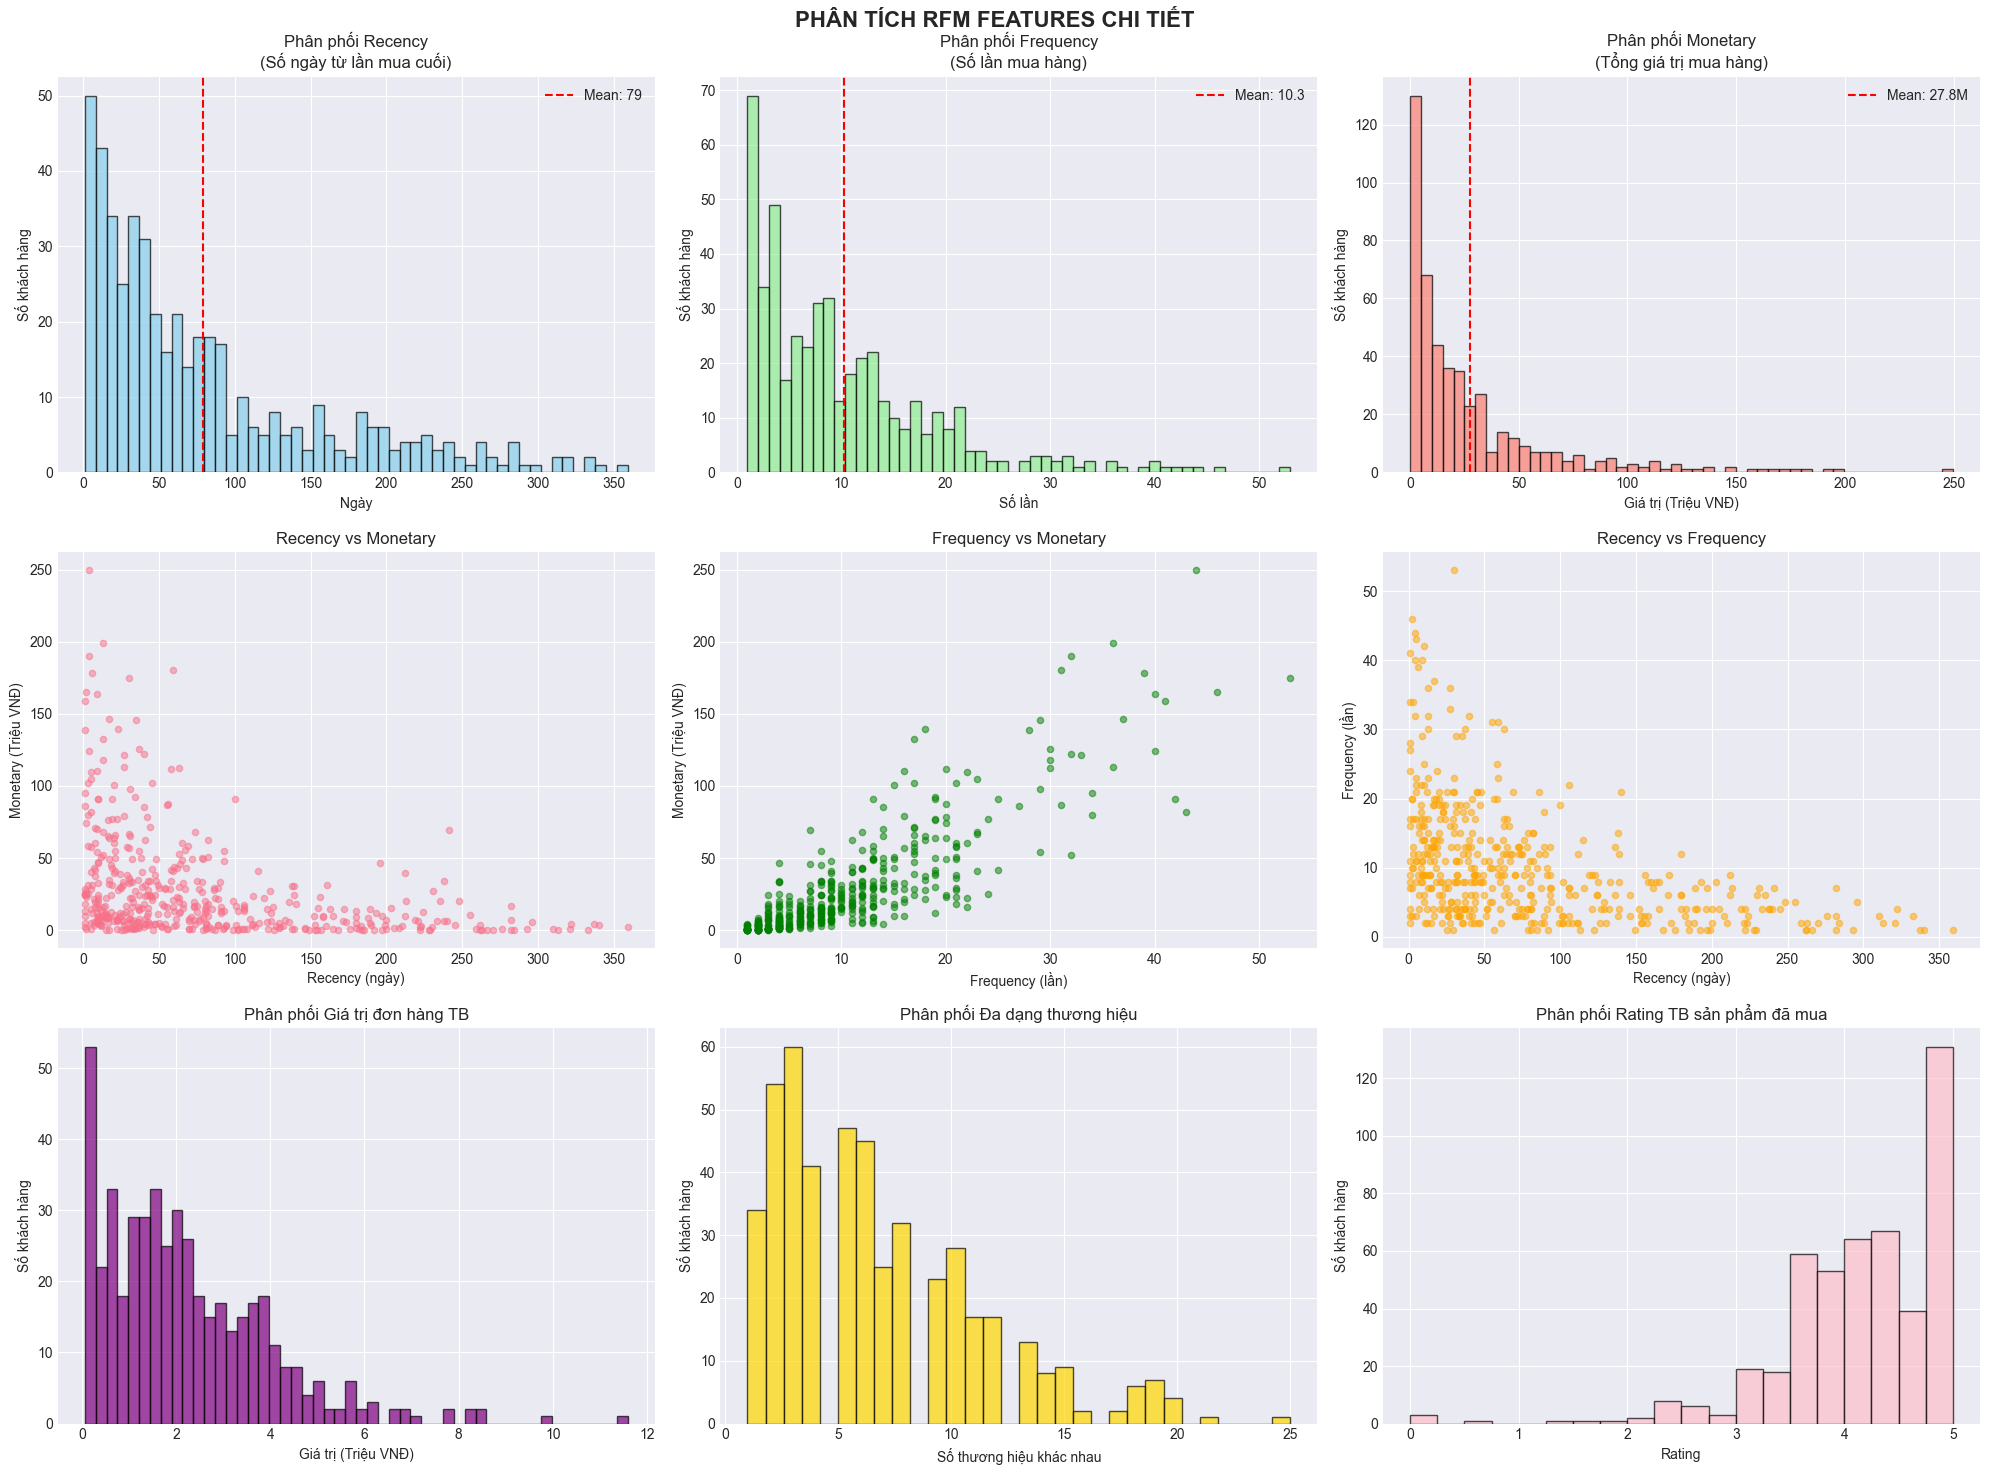

Saved chart: '04_rfm_analysis.png'


In [116]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('PHÂN TÍCH RFM FEATURES CHI TIẾT', fontsize=16, fontweight='bold')

# 1. Phân phối Recency
axes[0, 0].hist(rfm['Recency'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Phân phối Recency\n(Số ngày từ lần mua cuối)')
axes[0, 0].set_xlabel('Ngày')
axes[0, 0].set_ylabel('Số khách hàng')
axes[0, 0].axvline(rfm['Recency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Recency"].mean():.0f}')
axes[0, 0].legend()

# 2. Phân phối Frequency
axes[0, 1].hist(rfm['Frequency'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Phân phối Frequency\n(Số lần mua hàng)')
axes[0, 1].set_xlabel('Số lần')
axes[0, 1].set_ylabel('Số khách hàng')
axes[0, 1].axvline(rfm['Frequency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Frequency"].mean():.1f}')
axes[0, 1].legend()

# 3. Phân phối Monetary
axes[0, 2].hist(rfm['Monetary']/1000000, bins=50, edgecolor='black', alpha=0.7, color='salmon')
axes[0, 2].set_title('Phân phối Monetary\n(Tổng giá trị mua hàng)')
axes[0, 2].set_xlabel('Giá trị (Triệu VNĐ)')
axes[0, 2].set_ylabel('Số khách hàng')
axes[0, 2].axvline(rfm['Monetary'].mean()/1000000, color='red', linestyle='--', label=f'Mean: {rfm["Monetary"].mean()/1000000:.1f}M')
axes[0, 2].legend()

# 4. Scatter: Recency vs Monetary
axes[1, 0].scatter(rfm['Recency'], rfm['Monetary']/1000000, alpha=0.5, s=20)
axes[1, 0].set_title('Recency vs Monetary')
axes[1, 0].set_xlabel('Recency (ngày)')
axes[1, 0].set_ylabel('Monetary (Triệu VNĐ)')

# 5. Scatter: Frequency vs Monetary
axes[1, 1].scatter(rfm['Frequency'], rfm['Monetary']/1000000, alpha=0.5, s=20, color='green')
axes[1, 1].set_title('Frequency vs Monetary')
axes[1, 1].set_xlabel('Frequency (lần)')
axes[1, 1].set_ylabel('Monetary (Triệu VNĐ)')

# 6. Scatter: Recency vs Frequency
axes[1, 2].scatter(rfm['Recency'], rfm['Frequency'], alpha=0.5, s=20, color='orange')
axes[1, 2].set_title('Recency vs Frequency')
axes[1, 2].set_xlabel('Recency (ngày)')
axes[1, 2].set_ylabel('Frequency (lần)')

# 7. Phân phối Average Order Value
axes[2, 0].hist(rfm['AvgOrderValue']/1000000, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[2, 0].set_title('Phân phối Giá trị đơn hàng TB')
axes[2, 0].set_xlabel('Giá trị (Triệu VNĐ)')
axes[2, 0].set_ylabel('Số khách hàng')

# 8. Phân phối Brand Diversity
axes[2, 1].hist(rfm['BrandDiversity'], bins=30, edgecolor='black', alpha=0.7, color='gold')
axes[2, 1].set_title('Phân phối Đa dạng thương hiệu')
axes[2, 1].set_xlabel('Số thương hiệu khác nhau')
axes[2, 1].set_ylabel('Số khách hàng')

# 9. Phân phối Average Rating
axes[2, 2].hist(rfm['AvgRating'], bins=20, edgecolor='black', alpha=0.7, color='pink')
axes[2, 2].set_title('Phân phối Rating TB sản phẩm đã mua')
axes[2, 2].set_xlabel('Rating')
axes[2, 2].set_ylabel('Số khách hàng')

plt.tight_layout()
plt.savefig('04_rfm_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved chart: '04_rfm_analysis.png'")

Correlation matrix

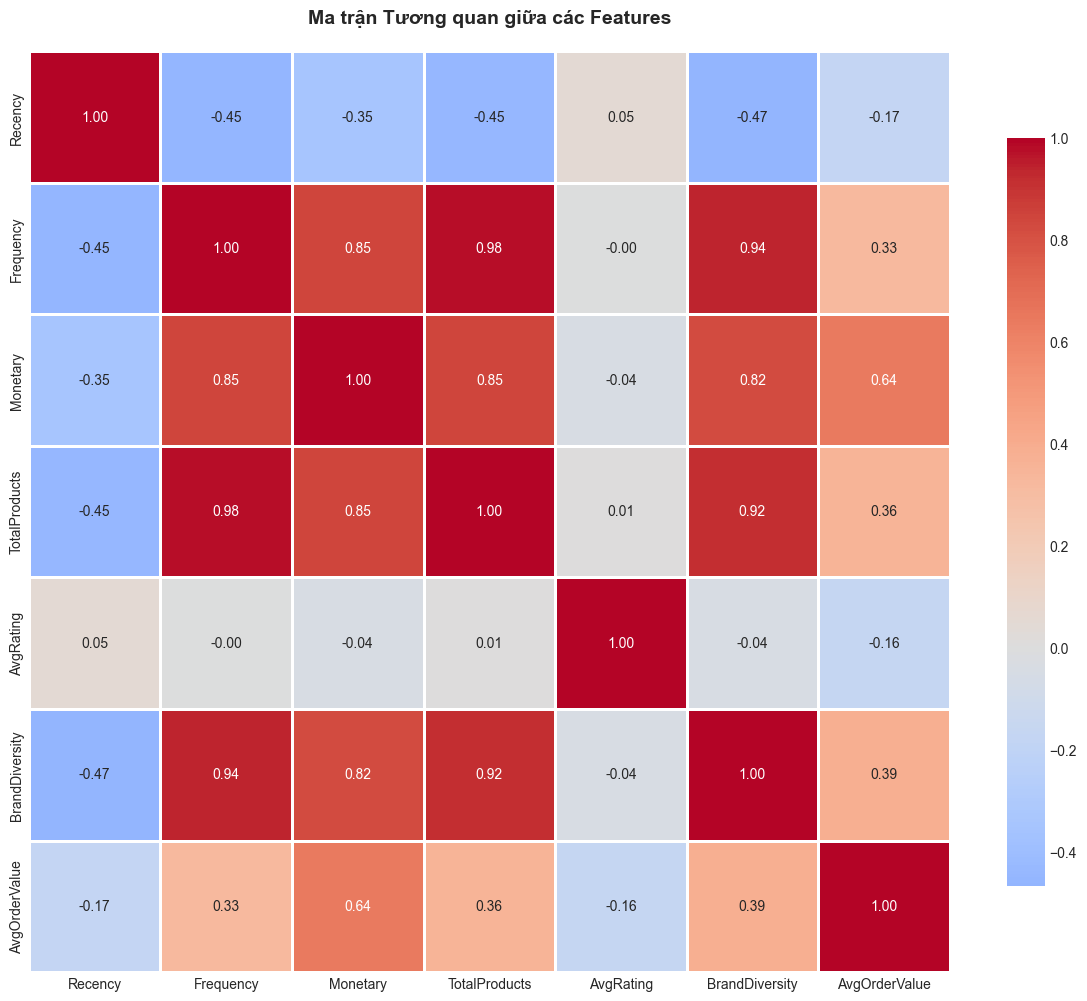

Saved chart: '05_correlation_matrix.png'

KEY CORRELATION ANALYSIS:

Strong correlation (|r| > 0.7):
   Frequency <-> Monetary: 0.846
   Frequency <-> TotalProducts: 0.981
   Frequency <-> BrandDiversity: 0.940
   Monetary <-> TotalProducts: 0.849
   Monetary <-> BrandDiversity: 0.824
   TotalProducts <-> BrandDiversity: 0.919

Average correlation (0.4 < |r| < 0.7):
   Recency <-> Frequency: -0.451
   Recency <-> TotalProducts: -0.445
   Recency <-> BrandDiversity: -0.466
   Monetary <-> AvgOrderValue: 0.641


In [ ]:
# Chọn các cột số để phân tích tương quan
numeric_cols = ['Recency', 'Frequency', 'Monetary', 'TotalProducts', 'AvgRating', 'BrandDiversity', 'AvgOrderValue']
correlation_matrix = rfm[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Ma trận Tương quan giữa các Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('05_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved chart: '05_correlation_matrix.png'")

print("\nKEY CORRELATION ANALYSIS:")
print("\nStrong correlation (|r| > 0.7):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            print(f"   {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {corr_value:.3f}")

print("\nNormal correlation (0.4 < |r| < 0.7):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if 0.4 < abs(corr_value) <= 0.7:
            print(f"   {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {corr_value:.3f}")


Before Kmeans

In [118]:
# Chọn features cho clustering (loại bỏ CustomerID)
features_for_clustering = ['Recency', 'Frequency', 'Monetary', 'TotalProducts', 'BrandDiversity', 'AvgOrderValue']
X = rfm[features_for_clustering].copy()

print(f"Features used for clustering: {features_for_clustering}")
print(f"Data shape: {X.shape}")

# Log transform cho các features có phân phối lệch
# print("\nApply Log Transformation to features:")
# X['Monetary_log'] = np.log1p(X['Monetary'])
# X['AvgOrderValue_log'] = np.log1p(X['AvgOrderValue'])
# X = X.drop(['Monetary', 'AvgOrderValue'], axis=1)
# print("Done.")

# Kiểm tra và xử lý outliers bằng IQR
print("\nSolving outliers using IQR:")
for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = ((X[col] < lower_bound) | (X[col] > upper_bound)).sum()
    if outliers_count > 0:
        print(f"{col}: {outliers_count} outliers detected")
        X[col] = X[col].clip(lower=lower_bound, upper=upper_bound)

# Chuẩn hóa dữ liệu (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("Done.")

print("\nAfter normalization:")
print(X_scaled_df.describe())

Features used for clustering: ['Recency', 'Frequency', 'Monetary', 'TotalProducts', 'BrandDiversity', 'AvgOrderValue']
Data shape: (476, 6)

Solving outliers using IQR:
Recency: 26 outliers detected
Frequency: 23 outliers detected
Monetary: 42 outliers detected
TotalProducts: 22 outliers detected
BrandDiversity: 13 outliers detected
AvgOrderValue: 12 outliers detected
Done.

After normalization:
            Recency   Frequency      Monetary  TotalProducts  BrandDiversity  \
count  4.760000e+02  476.000000  4.760000e+02     476.000000      476.000000   
mean  -8.956421e-17    0.000000 -5.970947e-17       0.000000        0.000000   
std    1.001052e+00    1.001052  1.001052e+00       1.001052        1.001052   
min   -1.061325e+00   -1.187539 -9.660528e-01      -1.209254       -1.264341   
25%   -7.796659e-01   -0.788150 -7.902037e-01      -0.816039       -0.809789   
50%   -3.501359e-01   -0.255631 -3.708820e-01      -0.215868       -0.127962   
75%    4.525923e-01    0.543147  4.111503

Find optimal k with Elbow Method

K=2: Inertia = 1437.87


K=3: Inertia = 1068.89
K=4: Inertia = 845.53
K=5: Inertia = 694.32
K=4: Inertia = 845.53
K=5: Inertia = 694.32
K=6: Inertia = 595.89
K=7: Inertia = 530.38
K=8: Inertia = 480.10
K=9: Inertia = 438.68
K=6: Inertia = 595.89
K=7: Inertia = 530.38
K=8: Inertia = 480.10
K=9: Inertia = 438.68
K=10: Inertia = 400.56

Elbow Method suggests optimal K = 3
K=10: Inertia = 400.56

Elbow Method suggests optimal K = 3


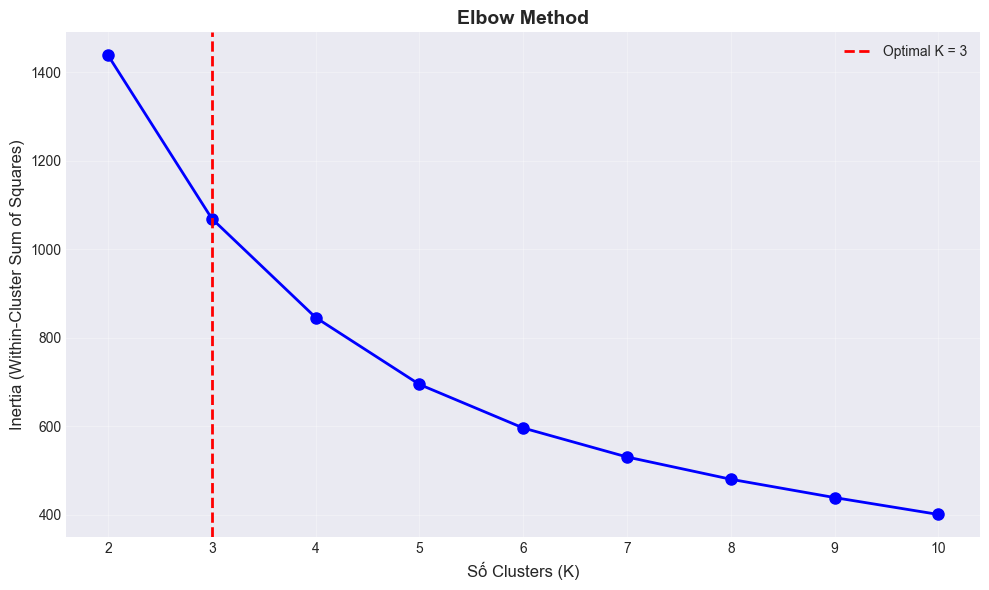

Saved chart: '06_elbow_method.png'


In [119]:
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"K={k}: Inertia = {kmeans.inertia_:.2f}")

# Tính toán elbow point bằng phương pháp gradient
differences = []
for i in range(1, len(inertias)):
    diff = inertias[i-1] - inertias[i]
    differences.append(diff)

# Tìm điểm có sự thay đổi lớn nhất (elbow)
max_diff_idx = differences.index(max(differences))
best_k = K_range[max_diff_idx + 1]

print(f"\nElbow Method suggests optimal K = {best_k}")

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K = {best_k}')
plt.xlabel('Số Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('06_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved chart: '06_elbow_method.png'")

Kmeans

In [120]:
print(f"K = {best_k}")
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=20, max_iter=300)
kmeans_final.fit(X_scaled)

# Dự đoán cluster cho mỗi khách hàng
rfm['Cluster'] = kmeans_final.labels_

print(f"Divided {len(rfm)} customers into {best_k} clusters")

print("\nCUSTOMER CLUSTERING:")
cluster_counts = rfm['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster +1}: {count} customers ({count/len(rfm)*100:.2f}%)")

# Thống kê trung bình của mỗi cluster
print("\nCLUSTER CHARACTERISTIC:")
# Sử dụng các cột gốc thay vì log-transformed columns
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'TotalProducts', 'BrandDiversity', 'AvgOrderValue']].mean()
display(cluster_summary)

# Các cluster
def name_cluster(row):
    if row['Frequency'] > rfm['Frequency'].quantile(0.75) and row['Monetary'] > rfm['Monetary'].quantile(0.75):
        return 'VIP Customers'
    elif row['Recency'] < rfm['Recency'].quantile(0.25) and row['Frequency'] > rfm['Frequency'].median():
        return 'Loyal Customers'
    elif row['Recency'] > rfm['Recency'].quantile(0.75):
        return 'At Risk'
    elif row['Frequency'] <= rfm['Frequency'].quantile(0.25):
        return 'New Customers'
    else:
        return 'Regular Customers'

cluster_names = cluster_summary.apply(name_cluster, axis=1)
print("\nCLUSTERS:")
for cluster, name in cluster_names.items():
    print(f"   Cluster {cluster}: {name}")
rfm['ClusterName'] = rfm['Cluster'].map(cluster_names)

rfm.to_csv('customer_segments.csv', index=False, encoding='utf-8-sig')
print("\nSaved customer clustering into 'customer_segments.csv'")

K = 3
Divided 476 customers into 3 clusters

CUSTOMER CLUSTERING:
Cluster 1: 93 customers (19.54%)
Cluster 2: 178 customers (37.39%)
Cluster 3: 205 customers (43.07%)

CLUSTER CHARACTERISTIC:


,Recency,Frequency,Monetary,TotalProducts,BrandDiversity,AvgOrderValue
Cluster,,,,,,
0,27.365591,23.709677,8.534912e+07,37.989247,13.677419,3.684603e+06
1,141.258427,3.550562,4.504194e+06,5.393258,2.820225,1.209115e+06
2,48.131707,10.068293,2.189090e+07,15.809756,6.707317,2.423415e+06



CLUSTERS:
   Cluster 0: VIP Customers
   Cluster 1: At Risk
   Cluster 2: Regular Customers

Saved customer clustering into 'customer_segments.csv'

   Cluster 0: VIP Customers
   Cluster 1: At Risk
   Cluster 2: Regular Customers

Saved customer clustering into 'customer_segments.csv'


Visualization clustering result

Number of clusters used: 3
PC1: 71.38%
PC2: 14.96%
Total: 86.33%


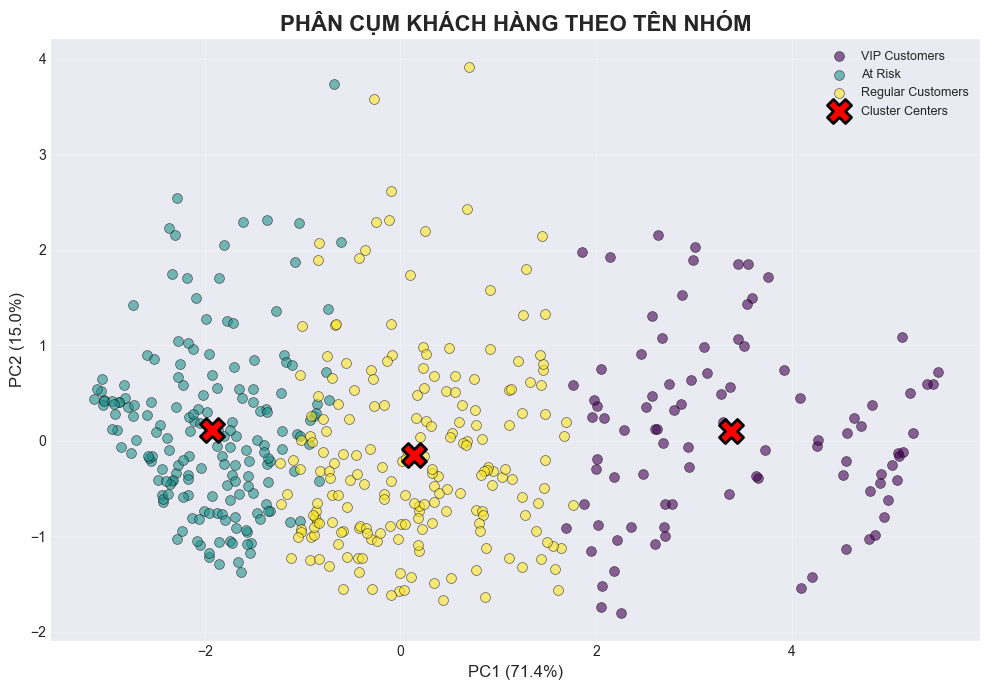

Saved chart: '07_clustering_visualization_2d.png'

STATISTICS OF 3 CLUSTER

VIP Customers (Cluster 0): 93 customers
Monetary TB: 85,349,125 VNĐ
Frequency TB: 23.7 lần
Recency TB: 27.4 ngày
AOV TB: 3,684,603 VNĐ

At Risk (Cluster 1): 178 customers
Monetary TB: 4,504,194 VNĐ
Frequency TB: 3.6 lần
Recency TB: 141.3 ngày
AOV TB: 1,209,115 VNĐ

Regular Customers (Cluster 2): 205 customers
Monetary TB: 21,890,897 VNĐ
Frequency TB: 10.1 lần
Recency TB: 48.1 ngày
AOV TB: 2,423,415 VNĐ


In [121]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"Number of clusters used: {best_k}")
print(f"PC1: {pca_2d.explained_variance_ratio_[0]*100:.2f}%")
print(f"PC2: {pca_2d.explained_variance_ratio_[1]*100:.2f}%")
print(f"Total: {sum(pca_2d.explained_variance_ratio_)*100:.2f}%")

plt.figure(figsize=(10, 7))
plt.title('PHÂN CỤM KHÁCH HÀNG THEO TÊN NHÓM', fontsize=16, fontweight='bold')
# Màu cho từng cụm
colors = plt.cm.viridis(np.linspace(0, 1, best_k))

# Vẽ các cụm với tên
for i, cluster_name in cluster_names.items():
    cluster_data = X_pca_2d[rfm['Cluster'] == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                c=[colors[i]], label=cluster_name, s=50, alpha=0.6, 
                edgecolors='black', linewidth=0.5)

# Vẽ tâm cụm
centers_2d = pca_2d.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
            c='red', marker='X', s=300, edgecolors='black', linewidth=2,
            label='Cluster Centers')

# Nhãn trục và chú thích
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('07_clustering_visualization_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved chart: '07_clustering_visualization_2d.png'")
print(f"\nSTATISTICS OF {best_k} CLUSTER")
for cluster_id, cluster_name in cluster_names.items():
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    print(f"\n{cluster_name} (Cluster {cluster_id}): {len(cluster_data)} customers")
    print(f"Monetary TB: {cluster_data['Monetary'].mean():,.0f} VNĐ")
    print(f"Frequency TB: {cluster_data['Frequency'].mean():.1f} lần")
    print(f"Recency TB: {cluster_data['Recency'].mean():.1f} ngày")
    print(f"AOV TB: {cluster_data['AvgOrderValue'].mean():,.0f} VNĐ")


Visualization 3D clustering result

Variance:
PC1: 71.38%
PC2: 14.96%
PC3: 11.07%
Total: 97.40%


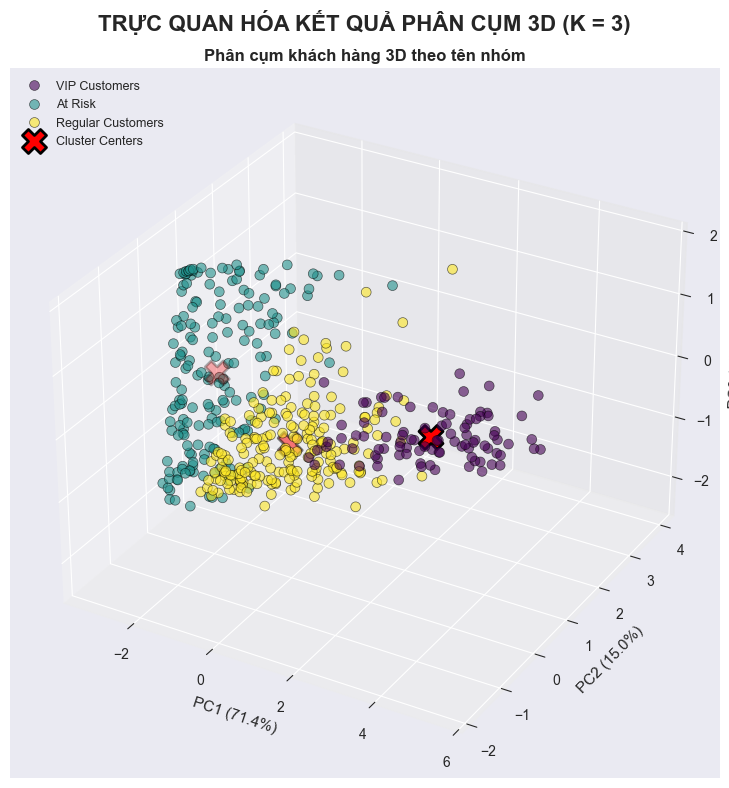

Saved chart: '08_clustering_visualization_3d.png'


In [122]:
from mpl_toolkits.mplot3d import Axes3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print(f"Variance:")
print(f"PC1: {pca_3d.explained_variance_ratio_[0]*100:.2f}%")
print(f"PC2: {pca_3d.explained_variance_ratio_[1]*100:.2f}%")
print(f"PC3: {pca_3d.explained_variance_ratio_[2]*100:.2f}%")
print(f"Total: {sum(pca_3d.explained_variance_ratio_)*100:.2f}%")
# Tạo biểu đồ 3D
fig = plt.figure(figsize=(20, 8))
# Vẽ cluster centers 3D
centers_3d = pca_3d.transform(kmeans_final.cluster_centers_)

# 3D với cluster names
ax2 = fig.add_subplot(111, projection='3d')
colors = plt.cm.viridis(np.linspace(0, 1, best_k))

for i, cluster_name in cluster_names.items():
    cluster_data_3d = X_pca_3d[rfm['Cluster'] == i]
    ax2.scatter(cluster_data_3d[:, 0], cluster_data_3d[:, 1], cluster_data_3d[:, 2],
               c=[colors[i]], label=cluster_name, s=50, alpha=0.6,
               edgecolors='black', linewidth=0.5)

# Vẽ cluster centers cho subplot 2
ax2.scatter(centers_3d[:, 0], centers_3d[:, 1], centers_3d[:, 2],
           c='red', marker='X', s=300, edgecolors='black', linewidth=2,
           label='Cluster Centers')

ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)
ax2.set_title('Phân cụm khách hàng 3D theo tên nhóm', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=9)

plt.suptitle(f'TRỰC QUAN HÓA KẾT QUẢ PHÂN CỤM 3D (K = {best_k})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('08_clustering_visualization_3d.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved chart: '08_clustering_visualization_3d.png'")
